In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table



In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo

# LET'S START WITH THE MASTER CATALOG FROM GOODS-S

In [4]:
master_cat = pd.read_fwf("data/MASTERCAT_v3.0.dat", sep=" ", skiprows=62, header=None)
master_cat.columns = ["id", "location", "location2", "RA", "DEC", "ZSPEC", "Quality"]
#add a column to keep track of which cat the line in the DF comes from
master_cat['Source'] = 'Master'

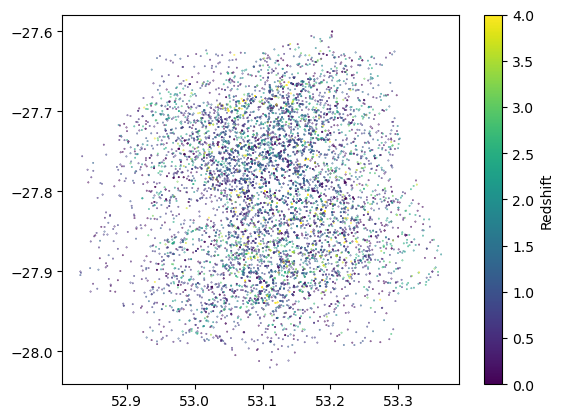

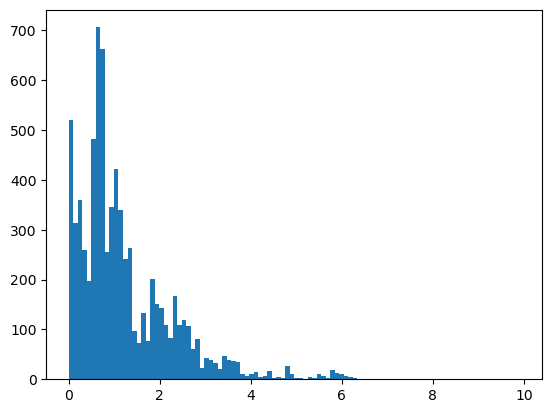

In [15]:
plt.scatter(master_cat['RA'], master_cat['DEC'], s = 0.1, c = master_cat['ZSPEC'], vmax = 4)
plt.colorbar(label = 'Redshift')
plt.figure()
plt.hist(master_cat['ZSPEC'], bins=100);

In [6]:
master_cat[master_cat['id']==18]["Quality"]

7371    NaN
7372    NaN
7373    NaN
7374    NaN
7375    NaN
       ... 
7576    NaN
7577    NaN
7578    NaN
7579    NaN
7580    NaN
Name: Quality, Length: 210, dtype: object

The first thing we notice is that while in the header it is written "3,4,5,6,7,10,11,13:   NO QF provided", all the GMASS quality flag (id=18) are missing. They can be retrieved from the web server at http://archive.eso.org/wdb/wdb/vo/goods_CDFS_master/form (local file wdb_query_13059_eso.csv)

In [10]:
goods_web = pd.read_csv("data/wdb_query_13059_eso.csv", comment="#")
#Let's make sure that the entries are in the same order
gmass_master = master_cat[master_cat["id"]==18]
assert len(goods_web)==len(gmass_master)
assert np.all(np.array(goods_web["Spect. z"])==np.array(gmass_master["ZSPEC"]))

In [353]:
#Reassign the quality flag to the GMASS. This is 0 or 1, 1 being a secure redshift
master_cat.loc[master_cat["id"]==18, "Quality"] = np.array(gmass_web["Quality flag"])
master_cat.loc[master_cat["id"]==18, "Source"] = "Master+web"
master_cat[master_cat['id']==18]

,id,location,location2,RA,DEC,ZSPEC,Quality,Source
7371,18,J033231.56-274853.8,GMASS0118,53.131508,-27.814948,1.8795,1,Master+web
7372,18,J033221.95-274855.6,GMASS0149,53.091466,-27.815463,2.0069,1,Master+web
7373,18,J033238.19-274849.4,GMASS0178,53.159159,-27.813750,1.7669,1,Master+web
7374,18,J033234.11-274849.5,GMASS0181,53.142153,-27.813773,2.3436,1,Master+web
7375,18,J033231.15-274847.9,GMASS0183,53.129829,-27.813320,1.8820,1,Master+web
...,...,...,...,...,...,...,...,...
7576,18,J033225.77-274459.3,GMASS1579,53.107383,-27.749812,0.8335,1,Master+web
7577,18,J033226.88-274541.9,GMASS1304,53.112039,-27.761642,0.3373,1,Master+web
7578,18,J033220.40-274542.1,GMASS1309,53.085011,-27.761718,0.9143,1,Master+web
7579,18,J033225.77-274501.7,GMASS1581,53.107390,-27.750492,0.0000,1,Master+web


Next we need to deal with the entries in master catalogue without quality flags, as we want to be able to select secure zspec. These are INDEF in the ascii file, but pandas ends up keeping only the letter F

In [13]:
no_qf_mask = master_cat["Quality"]=="F"
#we can check that it is equivalent to
#indef_mask = np.logical_or(master_cat["id"]==3, master_cat["id"]==4)
#indef_mask = np.logical_or(indef_mask, master_cat["id"]==5)
#indef_mask = np.logical_or(indef_mask, master_cat["id"]==6)
#indef_mask = np.logical_or(indef_mask, master_cat["id"]==7)
#indef_mask = np.logical_or(indef_mask, master_cat["id"]==10)
#indef_mask = np.logical_or(indef_mask, master_cat["id"]==11)
#indef_mask = np.logical_or(indef_mask, master_cat["id"]==13)
master_indef = master_cat[no_qf_mask]


The first thing we can try to do is to search for these indefinite flag cases in the CANDELS redshift catalog for GOODS-S from MAST  HLSP server : https://archive.stsci.edu/hlsp/candels/goods-s-catalogs

In [14]:
f =open('data/hlsp_candels_hst_wfc3_goodss_multi_v2_redshift-cat.txt')
#build the column names out of the header
names = f.readlines()[3:60]
names = [name[1:-2] for name in names]
names[:9] = [name[3:] for name in names[:9]]
names[10:] = [name[4:] for name in names[10:]]
f.close()
#now read the file as a DataFrame, and rename some columns to follow master conventions
candels_table = pd.read_csv('data/hlsp_candels_hst_wfc3_goodss_multi_v2_redshift-cat.txt', sep = ' ', \
                            skiprows=61, header=None, names=names)
candels_table.rename({'z_spec':'ZSPEC','RA (CANDELS.GOODSS.F160W.v1_1.photom.cat)':'RA',\
                      'DEC (CANDELS.GOODSS.F160W.v1_1.photom.cat)':'DEC'}, axis=1, inplace=True)
#remove entries without a zspec; if a zspec is present, it is from a robust measurement.
candels_table = candels_table[candels_table['ZSPEC']!=-1.]

In [386]:
# Spatial cross match
cat1_c = SkyCoord(ra=np.array(master_indef['RA'])*u.degree, dec=np.array(master_indef['DEC'])*u.degree)
cat2_c = SkyCoord(ra=np.array(candels_table['RA'])*u.degree, dec=np.array(candels_table['DEC'])*u.degree)
# cat2_c = SkyCoord(ra=np.array(specz_table['RA'])*u.degree, dec=np.array(specz_table['DEC'])*u.degree)
idx , d2d , d3d = cat1_c.match_to_catalog_sky(cat2_c)

master_indef.iloc[d2d<2.7e-5*u.degree]["ZSPEC"], candels_table.iloc[range(len(idx))]["ZSPEC"]

#for i in range(len(idx)):
#    if(d2d[i]>2.7e-5*u.degree):
#        print(i, idx[i], d2d[i].degree, candels_table.iloc[idx[i]]["z_best_type"],candels_table.iloc[idx[i]]["z_best"],\
#              master_indef.iloc[i]["ZSPEC"], candels_table.iloc[idx[i]]["RA"],candels_table.iloc[idx[i]]["DEC"],\
#             master_indef.iloc[i]["RA"], master_indef.iloc[i]["DEC"])

(3036    0.544
 3037    2.817
 3038    0.333
 3039    0.577
 3040    0.212
 3041    0.975
 3042    0.295
 3043    0.670
 3044    0.738
 3045    0.247
 3046    0.668
 3048    0.668
 3049    1.221
 3050    2.569
 3051    0.296
 3052    0.276
 3053    0.227
 3054    0.665
 3055    0.669
 3056    0.666
 3057    0.458
 3058    1.221
 3059    1.097
 3061    0.333
 3062    0.437
 3063    0.337
 3064    0.128
 3065    5.829
 3066    1.089
 3067    0.964
 3068    0.964
 3072    5.780
 3073    5.830
 3074    5.790
 3081    3.132
 3082    3.083
 3083    3.462
 3084    3.912
 3085    3.939
 3087    1.400
 3088    1.300
 3089    1.310
 3090    1.550
 3091    0.840
 3092    0.990
 3093    0.670
 3095    0.390
 3097    0.210
 3099    0.660
 3100    5.830
 Name: ZSPEC, dtype: float64,
 0      0.5303
 5      0.2528
 31     2.5640
 56     0.6190
 59     4.2130
 63     0.8232
 73     3.3502
 76     3.6230
 94     0.1788
 110    0.7328
 114    0.8060
 124    0.6190
 130    0.6700
 132    2.9778
 170    0.

In [347]:
specz_3d = fits.open('goodss_3dhst_v4.1.5_catalogs/goodss_3dhst.v4.1.5.zbest.fits')
specz_3d_table = Table(specz_3d[1].data)
specz_3d_df = specz_3d_table.to_pandas()
specz_3d_df[specz_3d_df["phot_id"]==23102]

,field,phot_id,z_best_s,use_phot,use_zgrism,z_best,z_best_l95,z_best_l68,z_best_u68,z_best_u95
23101,goodss,23102.0,1,1,1,0.665,-1.0,-1.0,-1.0,-1.0


In [198]:
#ESO GOODS
secure_mask = np.logical_and(master_cat["id"]==0, master_cat["Quality"]=="A")
secure_mask = np.logical_or(secure_mask, np.logical_and(master_cat["id"]==14, master_cat["Quality"]=="A"))
#VVDS
secure_mask = np.logical_or(secure_mask, np.logical_and(master_cat["id"]==1, master_cat["Quality"]=='4'))
secure_mask = np.logical_or(secure_mask, np.logical_and(master_cat["id"]==1, master_cat["Quality"]=='3'))
#Szokoly
secure_mask = np.logical_or(secure_mask, np.logical_and(master_cat["id"]==2, master_cat["Quality"]=='3'))
#Doherty
secure_mask = np.logical_or(secure_mask, np.logical_and(master_cat["id"]==8, master_cat["Quality"]=='3'))
#K20, GMASS
secure_mask = np.logical_or(secure_mask, np.logical_and(master_cat["id"]==15, master_cat["Quality"]=='1'))
secure_mask = np.logical_or(secure_mask, np.logical_and(master_cat["id"]==18, master_cat["Quality"]=='1'))
#IMAGES
secure_mask = np.logical_or(secure_mask, np.logical_and(master_cat["id"]==16, master_cat["Quality"]=='2'))
#SILVERMAN
secure_mask = np.logical_or(secure_mask, np.logical_and(master_cat["id"]==17, master_cat["Quality"]=='2'))
len(master_cat.loc[secure_mask, "id"])

3810

In [165]:
np.any(np.logical_and(master_cat["id"]==1, master_cat["Quality"]==4))

False

In [191]:
master_cat[master_cat["id"]==1]["Quality"][2734]#, master_cat["Quality"]==4

'4'

In [28]:
#we only want the secure ZSPEC :
#master_cat = master_cat[master_cat["Quality"] == "A"]
#master_cat.shape

In [29]:
#plt.scatter(master_cat['RA'], master_cat['DEC'], s = 0.1, c = master_cat['ZSPEC'], vmax = 4)
#plt.colorbar(label = 'Redshift')
#plt.figure()
#plt.hist(master_cat['ZSPEC'], bins=100);

equivalence goods_web     master_cat
```
"VIMOS VLT Deep Survey v1.0" 1
"X-ray CDFS (Szokoly et al. 2004)"   2
"Croom et al. (2000)"     3
"Dickinson et al. (2001)"    4
"van der Wel et al. (2004)"   5
"Bunker et al. (2003)"    6
"Stanway et al. (2004a)"     7
"LCIRS (Doherty et al. 2005)"    8
"Cristiani et al. (2000)"    10
"Strolger et al. (2004)"     11
"Stanway et al. (2004b)"     13
"VIMOS (Popesso et al. 2009; Balestra et al. 2010)"    14
"K20 (Mignoli et al. 2005)"   15
"IMAGES (Ravikumar et al. 2007)"   16
"Silverman et al. (2009)"    17
"GMASS (Kurk et al. 2012)"    18

```

In [115]:
web_mask = goods_web["Survey"]=="VIMOS VLT Deep Survey v1.0"
web_mask = np.logical_or(web_mask, goods_web["Survey"]=="X-ray CDFS (Szokoly et al. 2004)")
web_mask = np.logical_or(web_mask, goods_web["Survey"]=="Croom et al. (2000)")
web_mask = np.logical_or(web_mask, goods_web["Survey"]=="Dickinson et al. (2001)")
web_mask = np.logical_or(web_mask, goods_web["Survey"]=="van der Wel et al. (2004)")
web_mask = np.logical_or(web_mask, goods_web["Survey"]=="Bunker et al. (2003)")
web_mask = np.logical_or(web_mask, goods_web["Survey"]=="Stanway et al. (2004a)")
web_mask = np.logical_or(web_mask, goods_web["Survey"]=="LCIRS (Doherty et al. 2005)")
web_mask = np.logical_or(web_mask, goods_web["Survey"]=="Cristiani et al. (2000)")
web_mask = np.logical_or(web_mask, goods_web["Survey"]=="Strolger et al. (2004)")
web_mask = np.logical_or(web_mask, goods_web["Survey"]=="Stanway et al. (2004b)")
web_mask = np.logical_or(web_mask, goods_web["Survey"]=="VIMOS (Popesso et al. 2009; Balestra et al. 2010)")
web_mask = np.logical_or(web_mask, goods_web["Survey"]=="K20 (Mignoli et al. 2005)")
web_mask = np.logical_or(web_mask, goods_web["Survey"]=="IMAGES (Ravikumar et al. 2007)")
web_mask = np.logical_or(web_mask, goods_web["Survey"]=="Silverman et al. (2009)")
web_mask = np.logical_or(web_mask, goods_web["Survey"]=="GMASS (Kurk et al. 2012)")
goods_web[~web_mask].shape, master_cat[master_cat["id"]==0].shape

((1019, 7), (1138, 8))

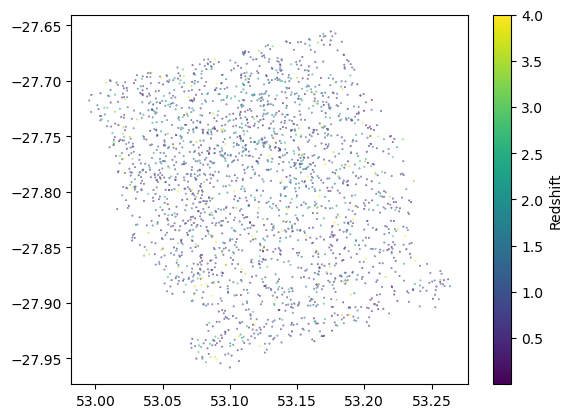

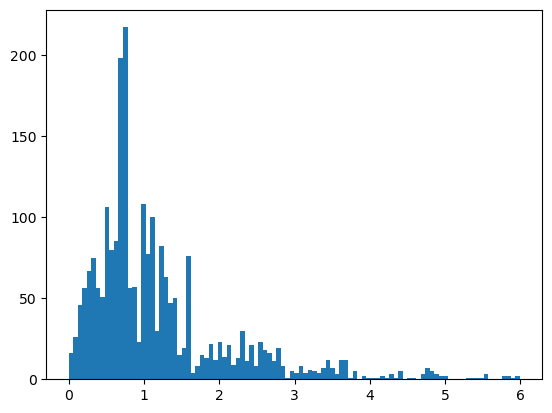

## 3D-HST (https://archive.stsci.edu/hlsp/candels/goods-s-catalogs)

In [280]:
specz_3d = fits.open('goodss_3dhst_v4.1.5_catalogs/goodss_3dhst.v4.1.5.zbest.fits')
specz_3d_table = Table(specz_3d[1].data)
specz_3d_df = specz_3d_table.to_pandas()
specz_3d_df

,field,phot_id,z_best_s,use_phot,use_zgrism,z_best,z_best_l95,z_best_l68,z_best_u68,z_best_u95
0,goodss,1.0,3,1,0,0.5041,0.482,0.486,0.522,0.526
1,goodss,2.0,3,0,0,2.8939,2.817,2.842,2.955,2.993
2,goodss,3.0,3,0,0,2.5998,2.527,2.558,2.649,2.662
3,goodss,4.0,3,1,0,0.1472,0.122,0.131,0.164,0.175
4,goodss,5.0,3,1,0,2.8316,2.777,2.787,2.877,2.888
...,...,...,...,...,...,...,...,...,...,...
50502,goodss,50503.0,3,1,0,1.8668,0.073,0.439,2.785,3.721
50503,goodss,50504.0,3,0,0,3.9020,0.222,1.736,5.775,5.946
50504,goodss,50505.0,3,1,0,1.0218,0.669,0.761,1.539,1.893
50505,goodss,50506.0,3,0,0,0.2207,0.027,0.092,0.326,0.466


In [ ]:
plt.scatter(specz_3d_df['RA'], specz_3d_df['DEC'], s = 0.1, c = specz_3d_df['ZSPEC'], vmax = 4)
plt.colorbar(label = 'Redshift')
plt.figure()
plt.hist(specz_3d_df['ZSPEC'], bins=100);

In [ ]:
candels_table["RA"], candels_table["DEC"], candels_table["ZSPEC"]

In [ ]:
master_cat["RA"], master_cat["DEC"], master_cat["ZSPEC"]

In [296]:
cat1_c = SkyCoord(ra=np.array(master_cat['RA'])*u.degree, dec=np.array(master_cat['DEC'])*u.degree)
cat2_c = SkyCoord(ra=np.array(candels_table['RA'])*u.degree, dec=np.array(candels_table['DEC'])*u.degree)
# cat2_c = SkyCoord(ra=np.array(specz_table['RA'])*u.degree, dec=np.array(specz_table['DEC'])*u.degree)
idx , d2d , d3d = cat1_c.match_to_catalog_sky(cat2_c)


In [297]:
idx[0],candels_table["ZSPEC"].iloc[idx[0]], candels_table["RA"].iloc[idx[0]], candels_table["DEC"].iloc[idx[0]], master_cat["ZSPEC"].iloc[0], master_cat["RA"].iloc[0], master_cat["DEC"].iloc[0]

(2269, 3.603, 53.0076811, -27.7018332, 3.603, 53.007675, -27.70182778)

In [ ]:
master_cat.iloc[0], candels_table.iloc[idx[0]]

In [ ]:
plt.hist(d2d.arcsec, 100);

In [ ]:
d2d.shape, d2d[d2d.arcsec>0.1].shape, master_cat.shape, candels_table.shape

In [300]:
goods_3dhst_cat=Table(fits.open("goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat.FITS")[1].data)
cat3_c = SkyCoord(ra=np.array(goods_3dhst_cat["ra"])*u.degree, dec=np.array(goods_3dhst_cat["dec"])*u.degree)

In [294]:
catgoods_3dhst_cat["ra"]

53.093012
53.089613
53.102913
53.101709
53.102277
53.090577
53.099964
53.096144
53.091572
53.091852
53.089615
